In [10]:
# ── Imports ───────────────────────────────────────────────
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy.matcher import PhraseMatcher
import matplotlib.pyplot as plt
from IPython.display import display

# ── NLP Setup ─────────────────────────────────────────────
nlp = spacy.load("en_core_web_sm")

# ── Skills ───────────────────────────────────────────────
SKILLS = [
    "python", "sql", "java", "javascript", "react", "aws", "azure", "docker",
    "machine learning", "deep learning", "data analysis", "statistics", "excel",
    "tableau", "power bi", "hr", "human resources", "recruitment",
    "talent acquisition", "onboarding", "employee relations",
    "performance management", "training", "leadership", "communication",
    "negotiation", "conflict resolution", "compliance", "labor law"
]

MUST_HAVE = ["recruitment", "performance management", "employee relations",
             "leadership", "communication"]

# Create PhraseMatcher once for efficiency
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(skill) for skill in SKILLS]
matcher.add("SKILLS", patterns)

# ── Functions ───────────────────────────────────────────

def clean_text(text):
    """Lowercase, remove numbers/punctuation, remove short words."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([w for w in text.split() if len(w) > 2])

def extract_skills(text):
    """Extract skills from text using pre-built PhraseMatcher."""
    if not text.strip(): return []
    doc = nlp(text[:150000])
    matches = matcher(doc)
    return sorted({doc[s:e].text for _, s, e in matches})

def skill_gap(res_skills, job_skills):
    """Return missing skills from job description."""
    return sorted(set(job_skills) - set(res_skills))

def compute_score(resume_texts, job_text, must_have=MUST_HAVE):
    """Compute weighted cosine similarity score between resumes and job."""
    vec = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
    tfidf = vec.fit_transform(resume_texts + [job_text])

    # Weight MUST_HAVE skills higher
    names = vec.get_feature_names_out()
    w = np.ones(len(names))
    for i, t in enumerate(names):
        if t in must_have:
            w[i] = 2.5

    weighted = tfidf.multiply(w).tocsr() # Convert to CSR matrix for slicing
    job_v = weighted[-1:]
    res_v = weighted[:-1]

    return cosine_similarity(res_v, job_v).flatten()

In [11]:
df = pd.read_csv("/content/Resume.csv", on_bad_lines='skip', engine='python')

In [12]:
# Detect correct resume column
resume_column = 'Resume_str' if 'Resume_str' in df.columns else 'Resume'

# Clean text & extract skills
df['clean'] = df[resume_column].apply(clean_text)
df['skills'] = df[resume_column].apply(extract_skills)

# Example job description
JOB = """
HR Manager
Lead recruitment and talent acquisition
Handle employee relations and performance management
Design training and development programs
Ensure compliance with labor laws
Strong leadership and communication skills
"""
job_clean = clean_text(JOB)
job_skills = extract_skills(JOB)

In [13]:
# Compute TF-IDF + cosine similarity with MUST_HAVE weighting
df['score'] = compute_score(df['clean'].tolist(), job_clean)

# Compute missing skills per candidate
df['gap'] = df['skills'].apply(lambda x: skill_gap(x, job_skills))

# Optional: Combine TF-IDF similarity with skill match ratio
df['skill_match_ratio'] = df['skills'].apply(lambda x: len(set(x) & set(job_skills))/len(job_skills))
df['final_score'] = 0.7 * df['score'] + 0.3 * df['skill_match_ratio']

# Rank candidates
ranked = df.sort_values('final_score', ascending=False)[
    ['ID', 'Category', 'final_score', 'skills', 'gap']
]

# Display top 10
display(ranked.head(10).style.format({
    'final_score': '{:.3f}',
    'skills': lambda x: ', '.join(x) if isinstance(x, list) else x,
    'gap': lambda x: ', '.join(x) if isinstance(x, list) else x
}))


,ID,Category,final_score,skills,gap
55,30862904,HR,0.682,"Employee Relations, HR, HUMAN RESOURCES, Human Resources, Leadership, RECRUITMENT, Recruitment, Training, communication, compliance, employee relations, human resources, leadership, negotiation, onboarding, performance management, recruitment, talent acquisition, training",
105,30563572,HR,0.613,"Communication, Compliance, Employee Relations, Employee relations, Excel, HR, Human Resources, Leadership, Performance management, Talent Acquisition, communication, compliance, employee relations, human resources, leadership, performance management, recruitment, training",talent acquisition
77,44476983,HR,0.557,"Excel, HR, Human Resources, Leadership, Recruitment, Training, communication, compliance, employee relations, human resources, leadership, performance management, recruitment, talent acquisition, training",
21,18827609,HR,0.522,"Employee Relations, Excel, HR, Human Resources, Leadership, Onboarding, Recruitment, Talent Acquisition, Training, communication, compliance, employee relations, leadership, onboarding, recruitment, training","performance management, talent acquisition"
57,28828844,HR,0.503,"Conflict resolution, Excel, HR, HUMAN RESOURCES, Hr, Human Resources, Training, communication, compliance, conflict resolution, employee relations, human resources, leadership, performance management, talent acquisition, training",recruitment
80,25724495,HR,0.503,"Communication, Employee Relations, Employee relations, HR, Human Resources, Leadership, Performance Management, Recruitment, Training, employee relations, excel, negotiation, onboarding, performance management, recruitment, training","communication, compliance, leadership, talent acquisition"
23,12786012,HR,0.484,"Employee Relations, Employee relations, Excel, HR, Human Resources, Human resources, Performance management, Training, communication, compliance, conflict resolution, employee relations, human resources, onboarding, performance management, recruitment, training","leadership, talent acquisition"
32,17855844,HR,0.482,"Employee Relations, Excel, HR, HUMAN RESOURCES, Human Resources, Performance Management, Recruitment, Training, compliance, employee relations, leadership, recruitment, training","communication, performance management, talent acquisition"
72,26289308,HR,0.465,"HR, communication, compliance, employee relations, human resources, performance management, recruitment, training","leadership, talent acquisition"
14,27490876,HR,0.456,"Compliance, Employee Relations, HR, Human Resources, Leadership, Recruitment, Training, compliance, employee relations, human resources, performance management, recruitment","communication, leadership, talent acquisition, training"


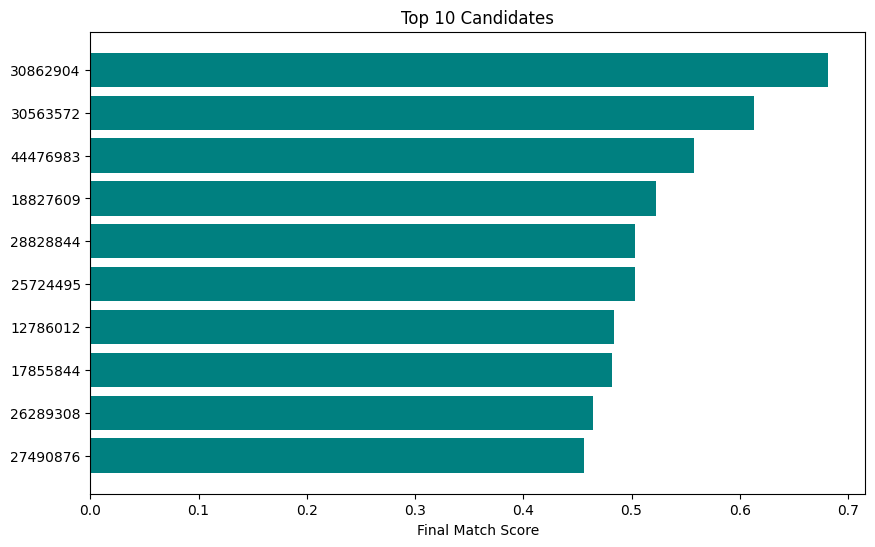

In [14]:
plt.figure(figsize=(10,6))
top = ranked.head(10)
plt.barh(top['ID'].astype(str), top['final_score'], color='teal')
plt.xlabel('Final Match Score')
plt.title('Top 10 Candidates')
plt.gca().invert_yaxis()
plt.show()


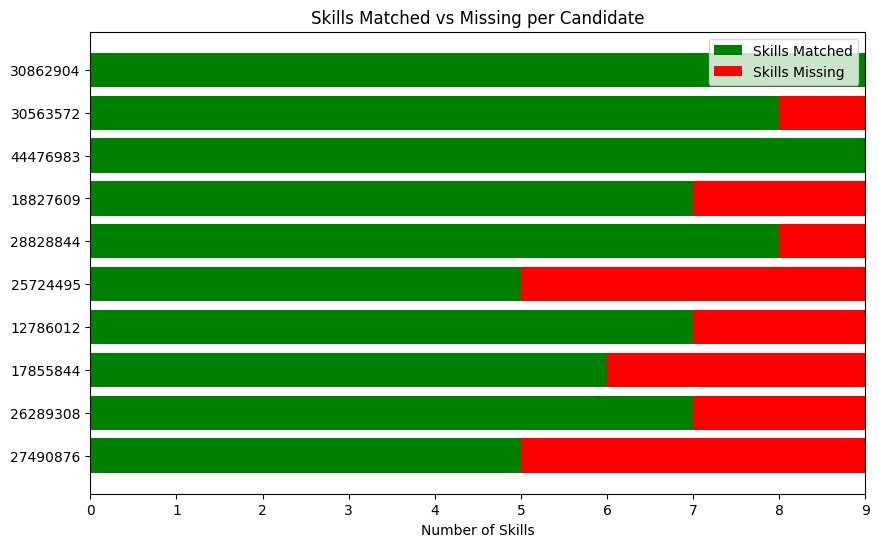

In [16]:
top = ranked.head(10)
skills_covered = [len(set(s) & set(job_skills)) for s in top['skills']]
skills_missing = [len(set(job_skills) - set(s)) for s in top['skills']]

plt.figure(figsize=(10,6))
plt.barh(top['ID'].astype(str), skills_covered, label='Skills Matched', color='green')
plt.barh(top['ID'].astype(str), skills_missing, left=skills_covered, label='Skills Missing', color='red')
plt.xlabel('Number of Skills')
plt.title('Skills Matched vs Missing per Candidate')
plt.legend()
plt.gca().invert_yaxis()
plt.show()


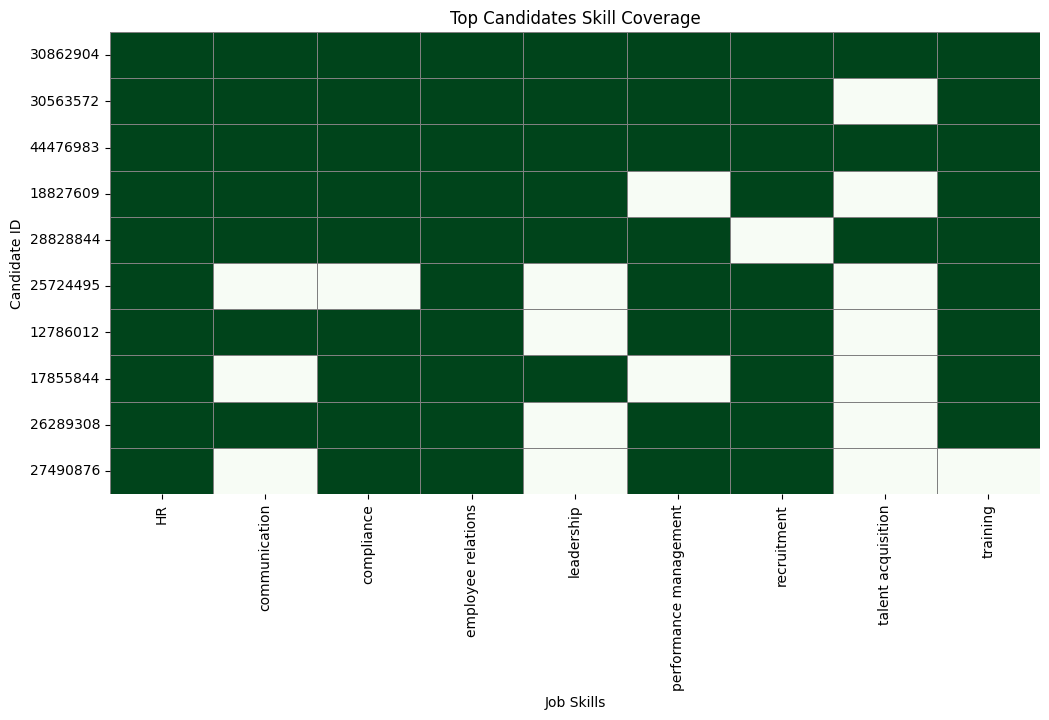

In [17]:
import seaborn as sns
import pandas as pd

heat_data = pd.DataFrame(index=top['ID'].astype(str), columns=job_skills)
for idx, row in top.iterrows():
    for skill in job_skills:
        heat_data.loc[str(row['ID']), skill] = 1 if skill in row['skills'] else 0

plt.figure(figsize=(12,6))
sns.heatmap(heat_data.astype(int), cmap='Greens', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Top Candidates Skill Coverage')
plt.xlabel('Job Skills')
plt.ylabel('Candidate ID')
plt.show()


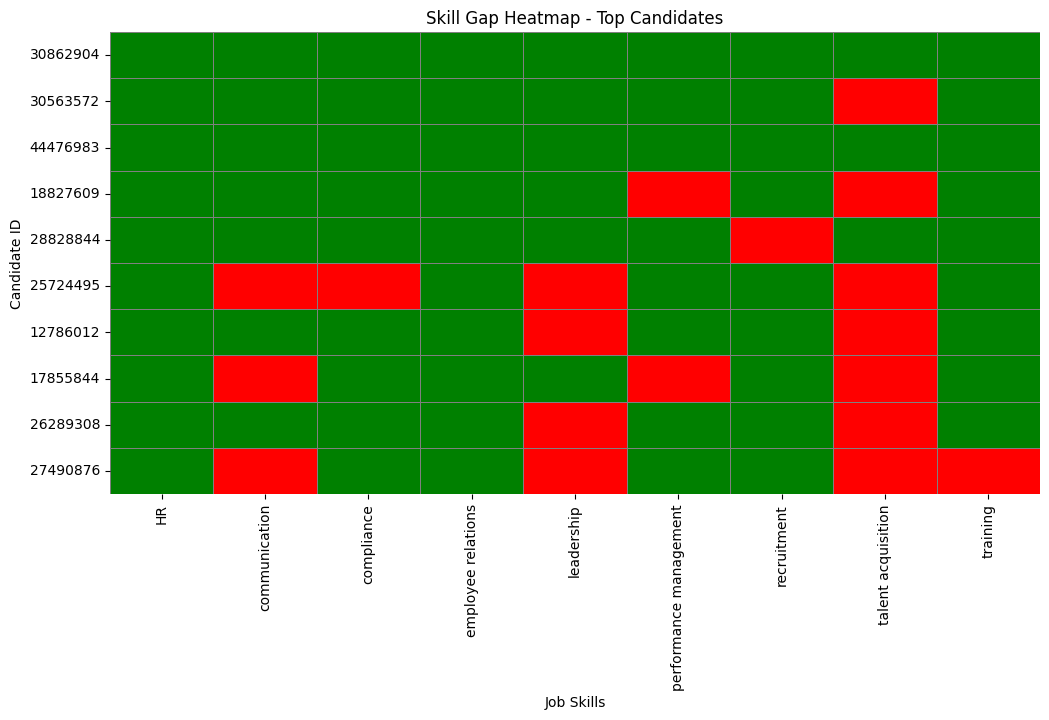

In [19]:
import seaborn as sns
import pandas as pd

heat_data = pd.DataFrame(index=top['ID'].astype(str), columns=job_skills)

for idx, row in top.iterrows():
    for skill in job_skills:
        heat_data.loc[str(row['ID']), skill] = 1 if skill in row['skills'] else 0

plt.figure(figsize=(12,6))
sns.heatmap(heat_data.astype(int), cmap=['red','green'], cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Skill Gap Heatmap - Top Candidates')
plt.xlabel('Job Skills')
plt.ylabel('Candidate ID')
plt.show()


In [23]:
for idx, row in top.iterrows():
    print(f"Candidate ID: {row['ID']}")
    print(f"Matched Skills: {', '.join(set(row['skills']) & set(job_skills))}")
    print(f"Missing Skills: {', '.join(set(job_skills) - set(row['skills']))}")
    print("-"*50)


Candidate ID: 30862904
Matched Skills: talent acquisition, compliance, communication, training, employee relations, HR, leadership, performance management, recruitment
Missing Skills: 
--------------------------------------------------
Candidate ID: 30563572
Matched Skills: compliance, communication, training, employee relations, HR, leadership, performance management, recruitment
Missing Skills: talent acquisition
--------------------------------------------------
Candidate ID: 44476983
Matched Skills: talent acquisition, compliance, communication, training, employee relations, HR, leadership, performance management, recruitment
Missing Skills: 
--------------------------------------------------
Candidate ID: 18827609
Matched Skills: compliance, communication, training, employee relations, HR, leadership, recruitment
Missing Skills: talent acquisition, performance management
--------------------------------------------------
Candidate ID: 28828844
Matched Skills: talent acquisition, c